<a href="https://www.kaggle.com/code/srsses/skin-cancer-detection?scriptVersionId=156349553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from glob import glob
import PIL
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPool2D,BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf

In [2]:
metadata = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")

In [3]:

metadata.drop(['lesion_id','dx_type','age','sex','localization'],axis = 1,inplace = True)
metadata.head(5)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [4]:
metadata.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [5]:
le = LabelEncoder()
metadata['dx'] = le.fit_transform(metadata.dx)

In [6]:
df1 = metadata[metadata.dx==0]
df2 = metadata[metadata.dx==1]
df3 = metadata[metadata.dx==2]
df4 = metadata[metadata.dx==3]
df5 = metadata[metadata.dx==4]
df6 = metadata[metadata.dx==5]
df7 = metadata[metadata.dx==6]

In [7]:
samples = 500
df1_balanced = resample(df1,replace = True,n_samples = samples,random_state = 2)
df2_balanced = resample(df2,replace = True,n_samples = samples,random_state = 2)
df3_balanced = resample(df3,replace = True,n_samples = samples,random_state = 2)
df4_balanced = resample(df4,replace = True,n_samples = samples,random_state = 2)
df5_balanced = resample(df5,replace = True,n_samples = samples,random_state = 2)
df6_balanced = resample(df6,replace = True,n_samples = samples,random_state = 2)
df7_balanced = resample(df7,replace = True,n_samples = samples,random_state = 2)

In [8]:
merged = pd.concat([df1_balanced,df2_balanced,df3_balanced,
                  df4_balanced,df5_balanced,df6_balanced,df7_balanced])

In [9]:
merged.image_id.value_counts()

ISIC_0026789    11
ISIC_0025911     9
ISIC_0030442     9
ISIC_0033808     9
ISIC_0030015     9
                ..
ISIC_0032567     1
ISIC_0030067     1
ISIC_0028830     1
ISIC_0025526     1
ISIC_0032932     1
Name: image_id, Length: 2159, dtype: int64

In [10]:
dir = "/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"
id = [x.split('.')[0] for x in os.listdir(dir)]
image_path = {x:os.path.join(dir,f'{x}.jpg') for x in id}

In [11]:
merged['path'] = metadata.image_id.map(image_path.get)

In [12]:
import PIL
from PIL import Image as img

In [13]:
merged['image'] = merged.path.map(lambda x:np.asarray(img.open(x).resize((80,80))))

In [14]:
merged

,image_id,dx,path,image
9855,ISIC_0029851,0,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[223, 192, 223], [220, 187, 213], [218, 177,..."
9702,ISIC_0027795,0,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[105, 50, 71], [103, 47, 72], [99, 45, 73], ..."
9759,ISIC_0030827,0,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[128, 85, 68], [134, 93, 76], [141, 97, 81],..."
9709,ISIC_0030242,0,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[222, 167, 177], [222, 168, 179], [222, 165,..."
9986,ISIC_0028517,0,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[157, 111, 131], [170, 123, 140], [175, 125,..."
...,...,...,...,...
2417,ISIC_0032409,6,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[229, 166, 176], [229, 167, 176], [232, 170,..."
2332,ISIC_0031217,6,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[114, 87, 100], [118, 91, 104], [123, 93, 10..."
2455,ISIC_0026467,6,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[235, 160, 182], [238, 162, 185], [240, 165,..."
2346,ISIC_0029514,6,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[64, 49, 54], [87, 71, 78], [116, 96, 107], ..."


In [15]:
merged.drop(['image_id','path'],axis = 1,inplace = True)

In [16]:
merged['image'] = merged.image.apply(lambda x: x/255)

In [17]:
x = np.asarray(merged['image'].tolist())
y = to_categorical(merged['dx'],num_classes = 7)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 4)

In [18]:
num_classes = 7
size = 80
model = Sequential()
model.add(Conv2D(256,(3,3), activation = "relu", input_shape = (size, size,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(7,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 39, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        7

In [19]:
model.compile(loss  = 'categorical_crossentropy', optimizer = 'Adam', metrics = 'acc')
batch_size = 64
epochs = 50
history = model.fit(x_train, y_train,epochs = epochs, batch_size= batch_size,
                   validation_data = (x_test,y_test), verbose = 2)
model.evaluate(x_test,y_test)

Epoch 1/50
42/42 - 10s - loss: 1.9277 - acc: 0.1958 - val_loss: 1.8637 - val_acc: 0.2023
Epoch 2/50
42/42 - 1s - loss: 1.8225 - acc: 0.2583 - val_loss: 1.7785 - val_acc: 0.2994
Epoch 3/50
42/42 - 1s - loss: 1.7331 - acc: 0.3059 - val_loss: 1.6799 - val_acc: 0.3189
Epoch 4/50
42/42 - 1s - loss: 1.6681 - acc: 0.3230 - val_loss: 1.6225 - val_acc: 0.3509
Epoch 5/50
42/42 - 1s - loss: 1.5748 - acc: 0.3722 - val_loss: 1.4614 - val_acc: 0.4023
Epoch 6/50
42/42 - 1s - loss: 1.4577 - acc: 0.4194 - val_loss: 1.5092 - val_acc: 0.3646
Epoch 7/50
42/42 - 1s - loss: 1.4032 - acc: 0.4434 - val_loss: 1.6077 - val_acc: 0.3886
Epoch 8/50
42/42 - 1s - loss: 1.3836 - acc: 0.4720 - val_loss: 1.3330 - val_acc: 0.4606
Epoch 9/50
42/42 - 1s - loss: 1.2864 - acc: 0.5044 - val_loss: 1.2526 - val_acc: 0.4937
Epoch 10/50
42/42 - 1s - loss: 1.2458 - acc: 0.5200 - val_loss: 1.3719 - val_acc: 0.4091
Epoch 11/50
42/42 - 1s - loss: 1.2104 - acc: 0.5368 - val_loss: 1.1776 - val_acc: 0.5349
Epoch 12/50
42/42 - 1s - loss

[0.9611397385597229, 0.7039999961853027]

In [20]:
np.random.randint(0,6000,1)

array([1317])

4


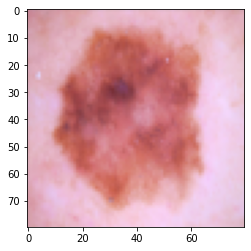

In [21]:
i = int(np.random.randint(0,6000,1))
plt.imshow(np.asarray(img.open(metadata.image_id.map({x:os.path.join(dir,f'{x}.jpg') for x in id}.get)[i]).resize((80,80))))
print(metadata.dx[i])

In [22]:
p = np.reshape(np.asarray(img.open(metadata.image_id.map({x:os.path.join(dir,f'{x}.jpg') for x in id}.get)[i]).resize((80,80))),(1,80,80,3))

In [23]:
print([round(x,3) for x in model.predict(p)[0]])
print(metadata.dx[i])

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
4
